In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import warnings

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

<IPython.core.display.Javascript object>

In [3]:
# https://gist.github.com/AdamSpannbauer/c99c366b0c7d5b6c4920a46c32d738e5
def print_vif(x):
    """Utility for checking multicollinearity assumption
    
    :param x: input features to check using VIF. This is assumed to be a pandas.DataFrame
    :return: nothing is returned the VIFs are printed as a pandas series
    """
    # Silence numpy FutureWarning about .ptp
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        x = sm.add_constant(x)

    vifs = []
    for i in range(x.shape[1]):
        vif = variance_inflation_factor(x.values, i)
        vifs.append(vif)

    print("VIF results\n-------------------------------")
    print(pd.Series(vifs, index=x.columns))
    print("-------------------------------\n")

<IPython.core.display.Javascript object>

* Read in and get to know the data.  We want to eventually predict `Profit`

In [4]:
data_url = "https://docs.google.com/spreadsheets/d/1RJrLftlRnj6gmrYewqxykVKSyl7aV-Ktd3sUNQILidM/export?format=csv"

<IPython.core.display.Javascript object>

In [7]:
startup = pd.read_csv(data_url)
startup.head()

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


<IPython.core.display.Javascript object>

In [8]:
startup.isna().sum()

R&D Spend          0
Administration     0
Marketing Spend    0
State              0
Profit             0
dtype: int64

<IPython.core.display.Javascript object>

In [10]:
startup.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   R&D Spend        50 non-null     float64
 1   Administration   50 non-null     float64
 2   Marketing Spend  50 non-null     float64
 3   State            50 non-null     object 
 4   Profit           50 non-null     float64
dtypes: float64(4), object(1)
memory usage: 2.1+ KB


<IPython.core.display.Javascript object>

In [11]:
startup.describe()

,R&D Spend,Administration,Marketing Spend,Profit
count,50.000000,50.000000,50.000000,50.000000
mean,73721.615600,121344.639600,211025.097800,112012.639200
std,45902.256482,28017.802755,122290.310726,40306.180338
min,0.000000,51283.140000,0.000000,14681.400000
25%,39936.370000,103730.875000,129300.132500,90138.902500
50%,73051.080000,122699.795000,212716.240000,107978.190000
75%,101602.800000,144842.180000,299469.085000,139765.977500
max,165349.200000,182645.560000,471784.100000,192261.830000


<IPython.core.display.Javascript object>

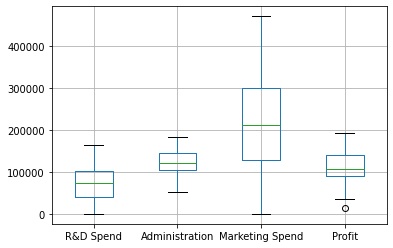

<IPython.core.display.Javascript object>

In [13]:
startup.boxplot()
plt.show()

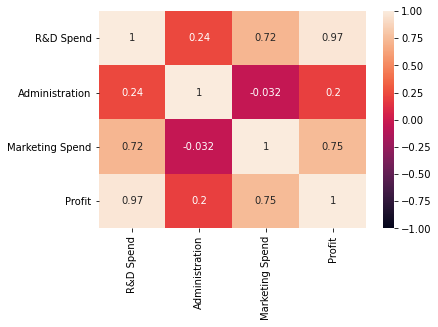

<IPython.core.display.Javascript object>

In [14]:
sns.heatmap(startup.corr(), vmin=-1, vmax=1, annot=True)
plt.show()

* Do we have an even distribution of states?  We'll eventually encode this variable to be numeric, how should we encode it? Which category would be the 'default'?

In [15]:
# Which category should we drop?
startup["State"].value_counts()

New York      17
California    17
Florida       16
Name: State, dtype: int64

<IPython.core.display.Javascript object>

* Create a pair plot with all of the data, what do you see?

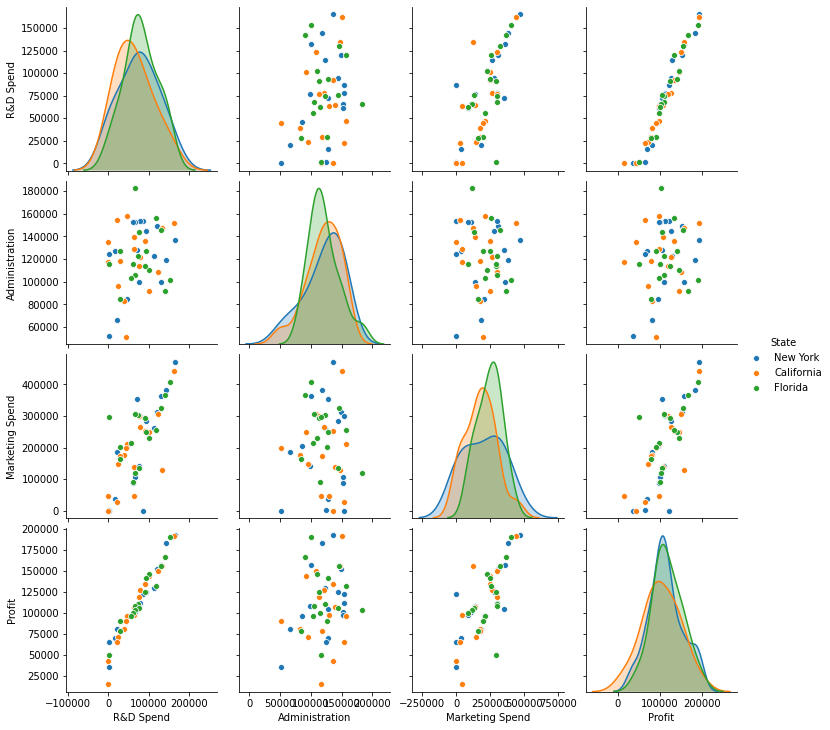

<IPython.core.display.Javascript object>

In [16]:
sns.pairplot(startup, hue="State")
plt.show()

* Create a train test split stratified by state

In [18]:
X = startup.drop(columns="Profit")
y = startup["Profit"]

<IPython.core.display.Javascript object>

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=X["State"]
)

<IPython.core.display.Javascript object>

* One hot encode

We'll take a look at using the `ColumnTransformer` today.  This is a way to write a 1 stop shop for all of your column preprocessing for a supervised learning model.  We can use it to one hot encode categorical variables and scale numeric variables all at once.

In [36]:
# Identify which columns are cat and num
# For one hot encoding, specify which categories to drop
cat_cols = ["State"]
drop_cats = ["California"]

num_cols = ["R&D Spend", "Administration", "Marketing Spend"]

<IPython.core.display.Javascript object>

----

Option showing how to onehotencode and leave numerics untouched

In [39]:
ct = ColumnTransformer(
    #   Format
    #   [("name of step 1" , WhatToDo1(), list_of_columns_to_do1_it_to),
    #    ("name of step 2" , WhatToDo2(), list_of_columns_to_do2_it_to)]
    [("one_hot_encode", OneHotEncoder(drop=drop_cats), cat_cols)],
    # Do nothing to the rest of the data
    remainder="passthrough",
)

<IPython.core.display.Javascript object>

In [40]:
ct = ColumnTransformer(
    [("one_hot_encode", OneHotEncoder(drop=drop_cats), cat_cols),],
    remainder="passthrough",
)

<IPython.core.display.Javascript object>

Option showing how to onehotencode and scale numerics

In [ ]:
# ct =ColumnTransformer(
#     [("one_hot_encode", OneHotEncoder(drop=drop_cats), cat_cols)],
#     # Scale the rest of the data
#     remainder=StandardScaler(),
# )

----

A big benefit of this is a single `fit` method that figures out how to one hot encode and scale and whatever else all at once.  We also have a single `transform` method that prepares all of our data at once.  This is a big big big plus for being able to predict on new data.

In [42]:
ct.fit(X_train)

X_train_trans = ct.transform(X_train)
X_test_trans = ct.transform(X_test)

X_train = pd.DataFrame(X_train_trans, index=X_train.index)
X_test = pd.DataFrame(X_test_trans, index=X_test.index)

X_train.head(2)

,0,1,2,3,4
41,1.0,0.0,27892.92,84710.77,164470.71
1,0.0,0.0,162597.70,151377.59,443898.53


<IPython.core.display.Javascript object>

The downside to this is it's harder to trackdown the variable
names :(

If we don't care about interpretability (just focused
on accuracy), this isn't terrible.  It's annoying if we care
about interpreting, and with linear regression we almost always care about interpreting coefficients.

This is admittedly, a pain.  Ugly code below to address the issue for this model.

In [43]:
cat_names = ct.transformers_[0][1].get_feature_names(cat_cols)
cat_names = list(cat_names)

new_col_names = cat_names + num_cols

X_train.columns = new_col_names
X_test.columns = new_col_names

X_train.head(2)

,State_Florida,State_New York,R&D Spend,Administration,Marketing Spend
41,1.0,0.0,27892.92,84710.77,164470.71
1,0.0,0.0,162597.70,151377.59,443898.53


<IPython.core.display.Javascript object>

Let's try and drive home why this is better than `pd.get_dummies` in a machine learning context.  For our model's to make any difference to the business they need to be 'deployed'; that is, they need to be living somewhere that they can receive new data and make predictions.

Let's say we run a website for people to judge how well a startup would do.  All users need to do is go to our website, fill out a form that asks them for the `'R&D Spend'`, `'Administration'`, `'Marketing Spend'`, and `'State'`.  Given this info, our model is expected to predict how much `'Profit'` we think the startup will have.

^This means that we'll get one new observation at a time.  Below is an example of what a user might input.

In [51]:
new_observation = pd.DataFrame(
    {
        "R&D Spend": [73721],
        "Administration": [121344],
        "Marketing Spend": [211025],
        "State": ["California"],
    }
)

new_observation

,R&D Spend,Administration,Marketing Spend,State
0,73721,121344,211025,California


<IPython.core.display.Javascript object>

For us to make a prediction, we need to reformat this data the same way we reformatted our original data.

In [52]:
# Reminder of what the training data looks like right now.
# Our new observation needs to match for our model to know
# what to do (column names optional, models dont care about them)
X_train.head(2)

,State_Florida,State_New York,R&D Spend,Administration,Marketing Spend
41,1.0,0.0,27892.92,84710.77,164470.71
1,0.0,0.0,162597.70,151377.59,443898.53


<IPython.core.display.Javascript object>

Maybe you'd think to use `pd.get_dummies()`. What's the issue with this?

In [53]:
pd.get_dummies(new_observation)

,R&D Spend,Administration,Marketing Spend,State_California
0,73721,121344,211025,1


<IPython.core.display.Javascript object>

This is where the extra work we put into the `ColumnTransformer()` pays off.

In [54]:
X_new = ct.transform(new_observation)
pd.DataFrame(X_new, columns=new_col_names)

,State_Florida,State_New York,R&D Spend,Administration,Marketing Spend
0,0.0,0.0,73721.0,121344.0,211025.0


<IPython.core.display.Javascript object>

------

* Check for multicollinearity with VIF

In [55]:
print_vif(X_train)

VIF results
-------------------------------
const              25.627989
State_Florida       1.421013
State_New York      1.399734
R&D Spend           2.505637
Administration      1.272084
Marketing Spend     2.195967
dtype: float64
-------------------------------



<IPython.core.display.Javascript object>

* Build a model using statsmodels and display the summary
    * Interpret $R^2$

In [57]:
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

model = sm.OLS(y_train, X_train_const).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Profit   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     133.8
Date:                Wed, 02 Sep 2020   Prob (F-statistic):           5.06e-20
Time:                        10:51:50   Log-Likelihood:                -389.10
No. Observations:                  37   AIC:                             790.2
Df Residuals:                      31   BIC:                             799.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            4.893e+04   8120.488      6.025      0.000    3.24e+04    6.55e+04
State_Florida     758.7380   4084.746      0.186      0.854   -7572.156    9089.632
State_New York   -825.8760   3975.320     -0.208      0.837   -8933.594    7281.842
R&D Spend           0.8193      0.054     15.216      0.000       0.709       0.929
Administration     -0.0562      0.064     -0.883      0.384      -0.186       0.074
Marketing Spend     0.0395      0.020      1.984      0.056      -0.001       0.080
==============================================================================
Omnibus:                        9.090   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.011   Jarque-Bera (JB):                8.472
Skew:                          -0.853   Prob(JB):                       0.0145
Kurtosis:                       4.609   Cond. No.                     1.49e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.49e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<IPython.core.display.Javascript object>

* Check the normality of residuals assumption with a qqplot

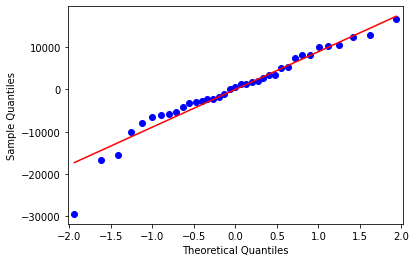

<IPython.core.display.Javascript object>

In [58]:
sm.qqplot(model.resid, line="s")
plt.show()

* Check the homoscedasticity assumption with `statsmodels`

In [60]:
_, p, _, _ = het_breuschpagan(model.resid, X_train_const)
p

0.6622564391228004

<IPython.core.display.Javascript object>

* Make a plot of actuals vs predicted

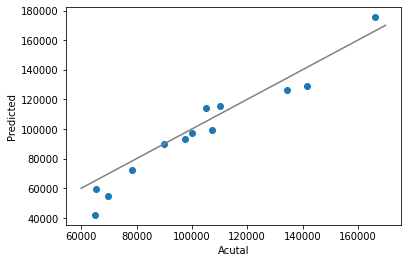

<IPython.core.display.Javascript object>

In [64]:
y_pred = model.predict(X_test_const)

plt.scatter(y_test, y_pred)
plt.plot([60000, 170000], [60000, 170000], c="gray")
plt.xlabel("Acutal")
plt.ylabel("Predicted")
plt.show()

* Calculate MAE, MAPE, MSE, & RMSE
  * Interpret MAE and MAPE

In [66]:
# Mean Absolute Error:
# When we make a prediction we are within $8,200 of the right answer
np.mean(np.abs(y_pred - y_test))

8210.00902943439

<IPython.core.display.Javascript object>

In [69]:
# Mean Absolute Percent Error
error = y_pred - y_test
percent_error = error / y_test

# When we make a prediction we are within 9% of the right answer
np.mean(np.abs(percent_error))

0.09192333969771202

<IPython.core.display.Javascript object>

In [70]:
# root mean squared error

# Main difference between this and MAE is this penalizes more for big mistakes
# We're 10K away from the right answer on average
error = y_pred - y_test
squared_error = error ** 2
mean_squared_error = np.mean(squared_error)

np.sqrt(mean_squared_error)

9971.451836287657

<IPython.core.display.Javascript object>

-------

#### Group A: 

Re-fit the model, but use either `QuantileTransformer()`, `StandardScaler()`, or `MinMaxScaler()`.

#### Group B:

Re-fit the model, but drop the predictor that was the worst predictor in our original model.

----

* Using the `statsmodels` output as a reference: Is your model performing better, worse, or no different than our original model? Which numbers back this up?
* Use `MAE` to evaluate your model.  Interpret this number for a business person.  According to this metric, how does your model perform compared to the original (again, express this as if you're talking to a business person).

In [ ]:
# You can write new code for this or modify the above existing code
# Modifying is prolly less effort


--------

Let's use `sklearn`'s `cross_val_score` to see a more 'stable' picture of your model's accuracy
* Use `cross_val_score` to calculate $R^2$
    * $R^2$ is the default score
    * We can choose from [a long list of scores](https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values) `sklearn` can do for us.

In [74]:
model = LinearRegression()

cross_val_score(model, X_train, y_train)

0.9059429914620367

<IPython.core.display.Javascript object>

In [76]:
model.fit(X_train, y_train)
model.score(X_train, y_train)

0.955698921753111

<IPython.core.display.Javascript object>

* Use `cross_val_score` with a different score than $R^2$